### Knowledge graphs and node classification

There are two special properties we are dealing with in this example:
1. We have one large graph and not many individual graphs (like molecules)
2. We infere on unlabeled nodes in this large graph and hence perform node-level predictions --> We have to use different nodes of the graph depending on what we want to do

There exists different datasets in PyTorch Geometric that can be used to perform Node Classification on large Knowledge Graphs e.g. Karate Network or Cora. We will use Cora to showcase the use of binary masks for node-level predictions.

#### What is the Cora Dataset?
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

- Nodes = Publications (Papers, Books ...)
- Edges = Citations
- Node Features = word vectors
- 7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, 	Probabilistic_Methods...

We normalize the features using torch geometric's transform functions.

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

Processing...
Done!


In [2]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


Observations For training:
- We only have a relatively small set of training nodes (20 nodes per class)
- There are binary test, train and validation masks of the size #nodes (they tell use which node can be used for which task)

In [3]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

Why do we even use the graph structure - aren't the features enough?

- Apparently, simple MLP models perform a lot worse than GNNs on this type of task, as the citation information is crucial for a correct classification


How do the labels look like?
- They are encoded as numeric value between 0-6

In [4]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [5]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [7]:
# example for the edge connections
data.edge_index.t()[:5]

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        [   2,    1],
        [ 652,    1]])

### Graph Neural Network for Node Classification

In [8]:
import torch
from torch.nn import Linear 
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # first message passing layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # second message passing layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)

        # output layer
        x = F.softmax(self.out(x), dim = 1)
        return x 
    
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


Observations:
- Dropout is only applied in the training step, but not for predictions
- We have 2 Message Passing Layers and one Linear output layer
- We use the softmax function for the classification problem
- The output of the model are 7 probabilities, one for each class

### Training and Evaluation

In [15]:
# initialize model
model = GCN(hidden_channels=16)

# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)
model = model.to(device)
data = data.to(device)

# initialize optimizer
LEARNING_RATE = 0.001
DECAY = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = LEARNING_RATE, 
                             weight_decay= DECAY)

# define loss function (cross entropy loss for classification problems with prob. distribution)
criterion = torch.nn.CrossEntropyLoss()

Device used:  cuda


In [16]:
def train():
    model.train()
    optimizer.zero_grad()
    # use all data as input, because all node have features
    out = model(data.x, data.edge_index)
    # only use nodes with labels for loss calculation
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # use the class with highest probabililty
    pred = out.argmax(dim=1)
    # check against the ground-truth labels
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    # derive ratio of correct predictions
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [17]:
losses = []
for epoch in range(0, 2001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")


Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.9441
Epoch: 200, Loss: 1.9233
Epoch: 300, Loss: 1.8014
Epoch: 400, Loss: 1.7025
Epoch: 500, Loss: 1.6509
Epoch: 600, Loss: 1.6268
Epoch: 700, Loss: 1.5984
Epoch: 800, Loss: 1.6135
Epoch: 900, Loss: 1.5895
Epoch: 1000, Loss: 1.5612
Epoch: 1100, Loss: 1.5524
Epoch: 1200, Loss: 1.5220
Epoch: 1300, Loss: 1.4851
Epoch: 1400, Loss: 1.4435
Epoch: 1500, Loss: 1.4642
Epoch: 1600, Loss: 1.4372
Epoch: 1700, Loss: 1.3653
Epoch: 1800, Loss: 1.3829
Epoch: 1900, Loss: 1.3626
Epoch: 2000, Loss: 1.3588


#### Visualize the training loss

<Axes: >

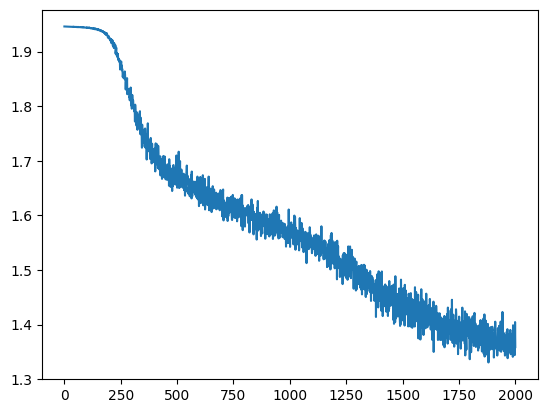

In [18]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(losses_float)
plt

#### Calculate the test metric

In [19]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7330


torch.Size([2708, 7])


<Axes: >

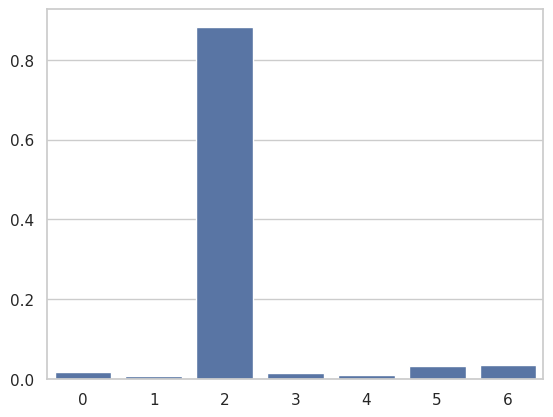

In [20]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())